In [1]:
import glob
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Dense,
    Dropout,
    Input,
    RepeatVector,
    TimeDistributed,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
pd.options.display.float_format = "{:.4f}".format

In [3]:
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_1.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_8.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_65.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_26.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_27.csv
# https://raw.githubusercontent.com/hnunezd/DSI/main/real_31.csv

url = "https://raw.githubusercontent.com/hnunezd/DSI/main/real_1.csv"
df = pd.read_csv(url)
df.shape

(1420, 3)

In [4]:
anom = df[df["is_anomaly"] == 1]

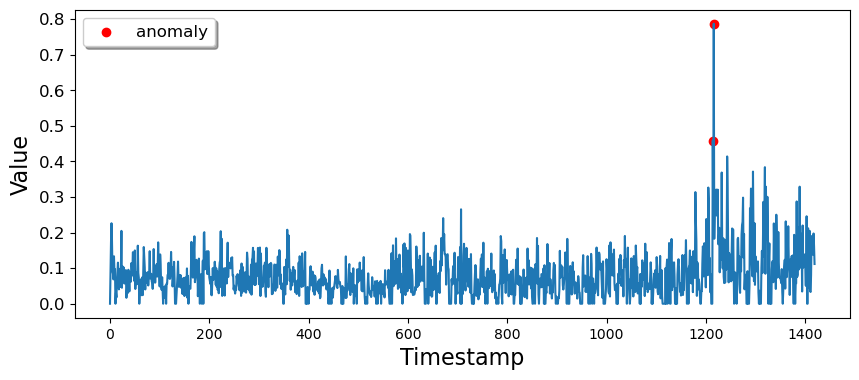

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df["value"])
plt.scatter(anom["timestamp"], anom["value"], c="red", label="anomaly")
plt.xlabel("Timestamp",fontsize=16)
plt.ylabel("Value",fontsize=16)
plt.yticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(shadow=True, fontsize=12)
#plt.savefig("/Users/hugonunez/Library/CloudStorage/OneDrive-Personal/Doctorado/Tesis/Proyecto Tesis/fig_examen/serie_65.pdf")
plt.show()

In [6]:
values = df.iloc[:, 1:2]
target = df["is_anomaly"]

In [7]:
test = int(len(df) * 0.5)

In [8]:
x_train = values[:test]
x_test = values[test : len(df)]

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_p = scaler.fit_transform(x_train)

In [10]:
scaled_test = scaler.fit_transform(x_test)

In [11]:
x_train_p, y_train_p = [], []
for i in range(8, len(scaled_data_p)):
    x_train_p.append(scaled_data_p[i - 8 : i])
    y_train_p.append(scaled_data_p[i])
x_train_p, y_train_p = np.array(x_train_p), np.array(y_train_p)

In [12]:
x_test_p, y_test_p = [], []
for i in range(8, len(scaled_test)):
    x_test_p.append(scaled_test[i - 8 : i])
    y_test_p.append(scaled_test[i])
x_test_p, y_test_p = np.array(x_test_p), np.array(y_test_p)

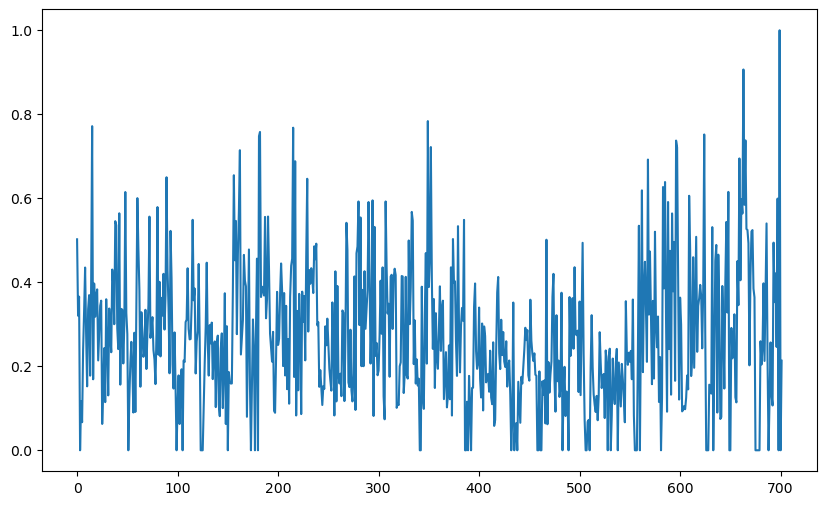

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_train_p)
plt.show()

In [14]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(64, input_shape=(8, 1), return_sequences=True))
model_lstm.add(tf.keras.layers.ReLU())
model_lstm.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True))
model_lstm.add(tf.keras.layers.ReLU())
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(16, recurrent_dropout=0.2, return_sequences=False))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(1))

In [15]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 64)             16896     
                                                                 
 re_lu (ReLU)                (None, 8, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 32)             12416     
                                                                 
 re_lu_1 (ReLU)              (None, 8, 32)             0         
                                                                 
 dropout (Dropout)           (None, 8, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

model_lstm.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.metrics.MeanAbsoluteError()],
)

history = model_lstm.fit(
    x_train_p,
    y_train_p,
    validation_split=0.2,
    batch_size=80,
    shuffle=False,
    epochs=200,
    callbacks=[early_stopping],
)

In [17]:
predictions_lstm = model_lstm.predict(x_train_p)

22/22 [==============================] - 1s 5ms/step


In [18]:
predictions_lstm1 = model_lstm.predict(x_test_p)

22/22 [==============================] - 0s 5ms/step


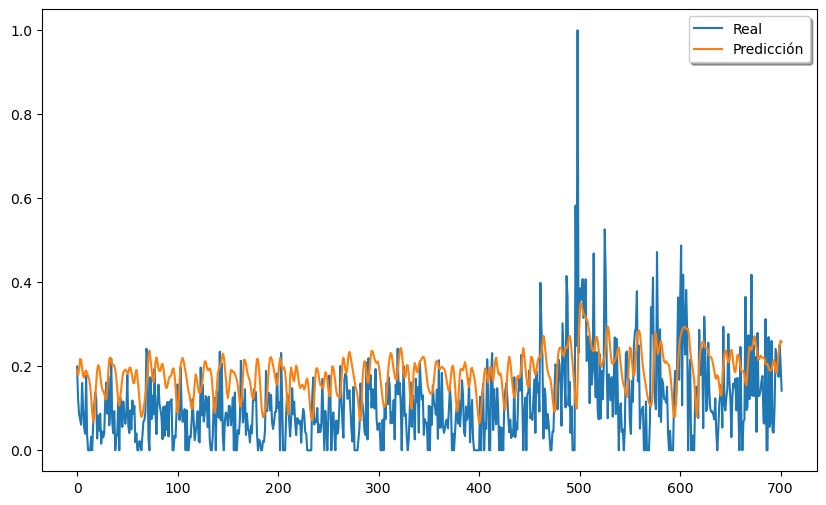

In [20]:
plt.figure(figsize=(10, 6))
# plt.xlim(1900,2100)
plt.plot(y_test_p, label="Real")

plt.plot(predictions_lstm1, label="Predicción")
plt.legend(shadow=True)
plt.show()

In [21]:
df_1 = pd.DataFrame()

In [22]:
df_1["real"] = pd.DataFrame(y_test_p)

In [23]:
df_1["pred"] = predictions_lstm1

In [24]:
df_1["anomaly"] = target[test + 8 : len(df)].values

In [25]:
df_1["Error"] = (df_1.real - df_1.pred) ** 2

In [26]:
media = np.mean(df_1.Error)
ds = np.std(df_1.Error)

In [27]:
lower_p = -3.5 * ds
upper_p = +3.5 * ds

In [28]:
#anomalias_p = df_1[(df_1.Error < lower_p) | (df_1.Error > upper_p)]
anomalias_p = df_1[df_1.Error > upper_p]

In [29]:
anomalias_p

,real,pred,anomaly,Error
496,0.5827,0.1132,1,0.2204
498,1.0000,0.1562,1,0.7119


In [30]:
Counter(anomalias_p["anomaly"])

Counter({1: 2})

In [31]:
anom=df_1[df_1["anomaly"] == 1]

In [32]:
#df_1["pred"] = np.where((df_1.Error < lower_p) | (df_1.Error > upper_p), 1, 0)

In [33]:
df_1["score"] = (df_1["Error"] - np.min(df_1.Error)) / (
    np.max(df_1.Error) - np.min(df_1.Error)
)

In [34]:
df_1["score"].sort_values(ascending=False).head(30)

498   1.0000
496   0.3096
525   0.1277
608   0.1172
573   0.0865
539   0.0842
464   0.0839
444   0.0830
72    0.0790
571   0.0781
323   0.0777
514   0.0762
560   0.0723
577   0.0719
146   0.0698
491   0.0693
202   0.0677
659   0.0670
528   0.0669
611   0.0665
180   0.0663
601   0.0628
651   0.0608
493   0.0604
623   0.0604
687   0.0593
686   0.0583
665   0.0581
551   0.0579
329   0.0575
Name: score, dtype: float64

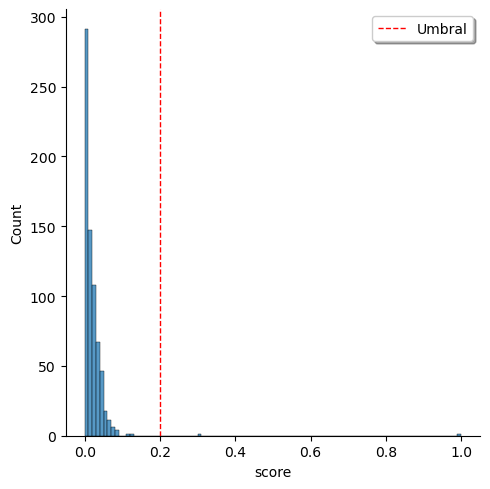

In [35]:
sns.displot(data=df_1, x="score",bins=100)
plt.axvline(0.2, color="red", linewidth = 1, linestyle = "dashed",label="Umbral");
plt.legend(shadow=True)
#plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/lstm_umbral_1.pdf")
plt.show()

In [36]:
umbral = 0.2

In [37]:
df_1["pred_score"] = np.where(df_1.score > umbral, 1, 0)

In [38]:
df_1[df_1["pred_score"] == 1]

,real,pred,anomaly,Error,score,pred_score
496,0.5827,0.1132,1,0.2204,0.3096,1
498,1.0000,0.1562,1,0.7119,1.0000,1


In [39]:
print(classification_report(df_1.anomaly, df_1.pred_score))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       1.00      1.00      1.00         2

    accuracy                           1.00       702
   macro avg       1.00      1.00      1.00       702
weighted avg       1.00      1.00      1.00       702



In [40]:
# df_1.to_excel("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/Codigos/resultados/lstm_27.xlsx")

In [41]:
anom_score=df_1[df_1["pred_score"] == 1]

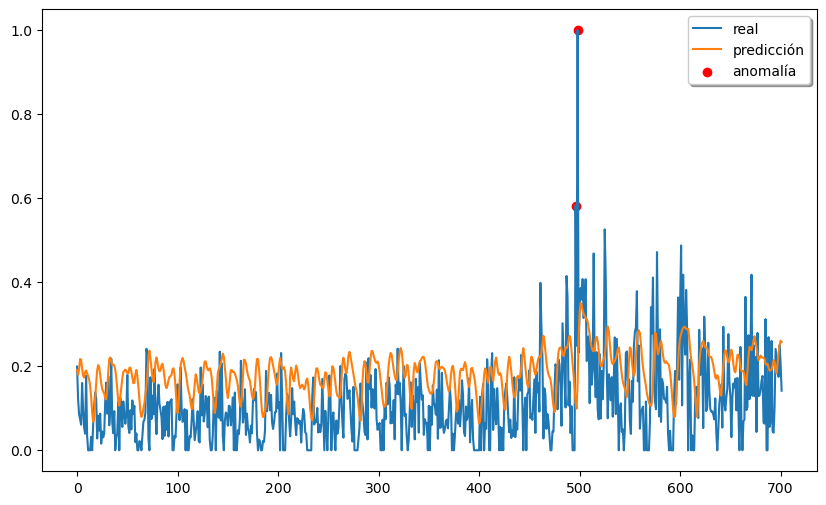

In [42]:
plt.figure(figsize=(10, 6))
# plt.xlim(1900,2100)
plt.plot(y_test_p, label="real")
plt.plot(predictions_lstm1,label="predicción")
plt.scatter(anom.index, anom.real, c="red",label="anomalía")
#plt.scatter(anom_score.index, anom_score.real, c="#00ff80", alpha=0.7,marker="*",label="posible anomalía")
plt.legend(shadow=True)
#plt.savefig("/Users/hugonunez/Library/CloudStorage/OneDrive-Personal/Doctorado/Tesis/Proyecto Tesis/fig_examen/lstm_pred_31.pdf")
plt.show()